## Plant Disease Prediction

In [1]:
# Set Parameters

# Samples per class in Traing Dataset
TRAIN_SAMPLES = 250

# Samples per class in Validation Dataset
VAL_SAMPLES = 50

# Batch Size for all Datasets
BATCH_SIZE = 32

# Maximum number of Epochs for Training
EPOCHS = 50

In [2]:
# Import Modules
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import keras.layers as layers
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import Model
from keras import regularizers
from sklearn.utils import shuffle
from matplotlib.image import imread
from keras.optimizers import Adamax
from keras.callbacks import Callback
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder


#### Get Dataset from Kaggle

In [3]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download -d saroz014/plant-disease
clear_output()


In [4]:
# Unzip Dataset
!tar -xf plant-disease.zip


In [5]:
# Delete Unwanted Files
!del plant-disease.zip
!rmdir /s/q "dataset/dataset"
%cd ..
clear_output()


#### Cleaning Data

In [6]:
# Deleting bad files in dataset
def delete_bad_files(dataset_path):
    num_bad_files = 0
    directories = os.listdir(dataset_path)
    for directory in directories:
        path = f'{dataset_path}/{directory}'
        files = os.listdir(path)
        for file in files:
            try:
                img = Image.open(f'{path}/{file}')
                if img.size != (256, 256) or img.mode != 'RGB':
                    del img
                    os.remove(f'{path}/{file}')
                    num_bad_files += 1
            except:
                os.remove(f'{path}/{file}')
                num_bad_files += 1
    return num_bad_files


num_bad_files_train = delete_bad_files('dataset/dataset/train')
num_bad_files_test = delete_bad_files('dataset/dataset/test')

print(f'deleted {num_bad_files_train} bad files from train dataset')
print(f'deleted {num_bad_files_test} bad files from test dataset')


deleted 1 bad files from train dataset
deleted 0 bad files from test dataset


#### Loading FilePaths in Pandas DataFrame

In [7]:
def load_filepaths(path):
    labels = []
    file_names = []
    directories = os.listdir(path)
    for directory in directories:
        files = os.listdir(f'{path}/{directory}')
        for file in files:
            labels.append(directory)
            file_names.append(f'{path}/{directory}/{file}')

    labels = pd.Series(data=labels, name='label')
    file_names = pd.Series(data=file_names, name='file_name')

    return pd.concat([labels, file_names], axis=1)


train_df = load_filepaths('dataset/dataset/train')
test_df = load_filepaths('dataset/dataset/test')


#### Vizualizing Some Data

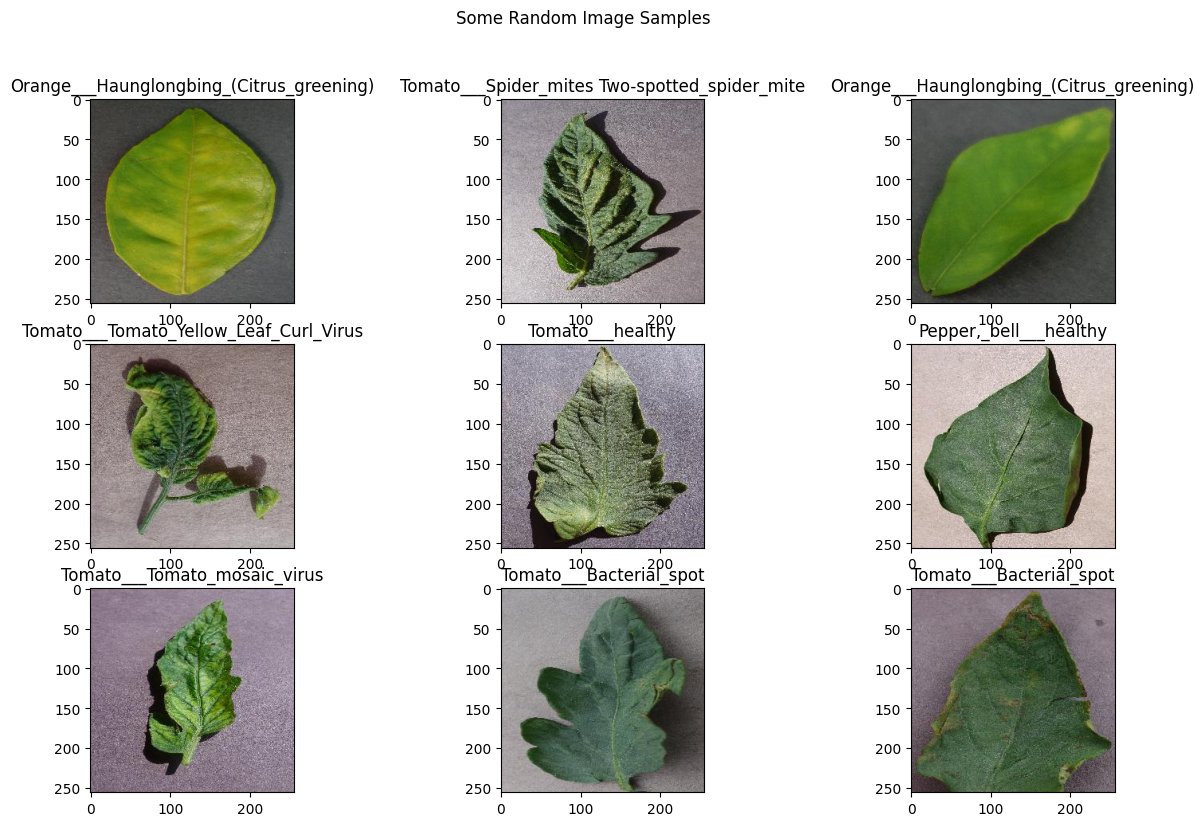

In [8]:
# Vizualize some random images
images = train_df.sample(n=9)
fig, ax = plt.subplots(3, 3, figsize=(15, 9))
fig.suptitle('Some Random Image Samples')
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        img = imread(images.iloc[k, 1])
        ax[i][j].imshow(img)
        ax[i][j].set_title(images.iloc[k, 0])


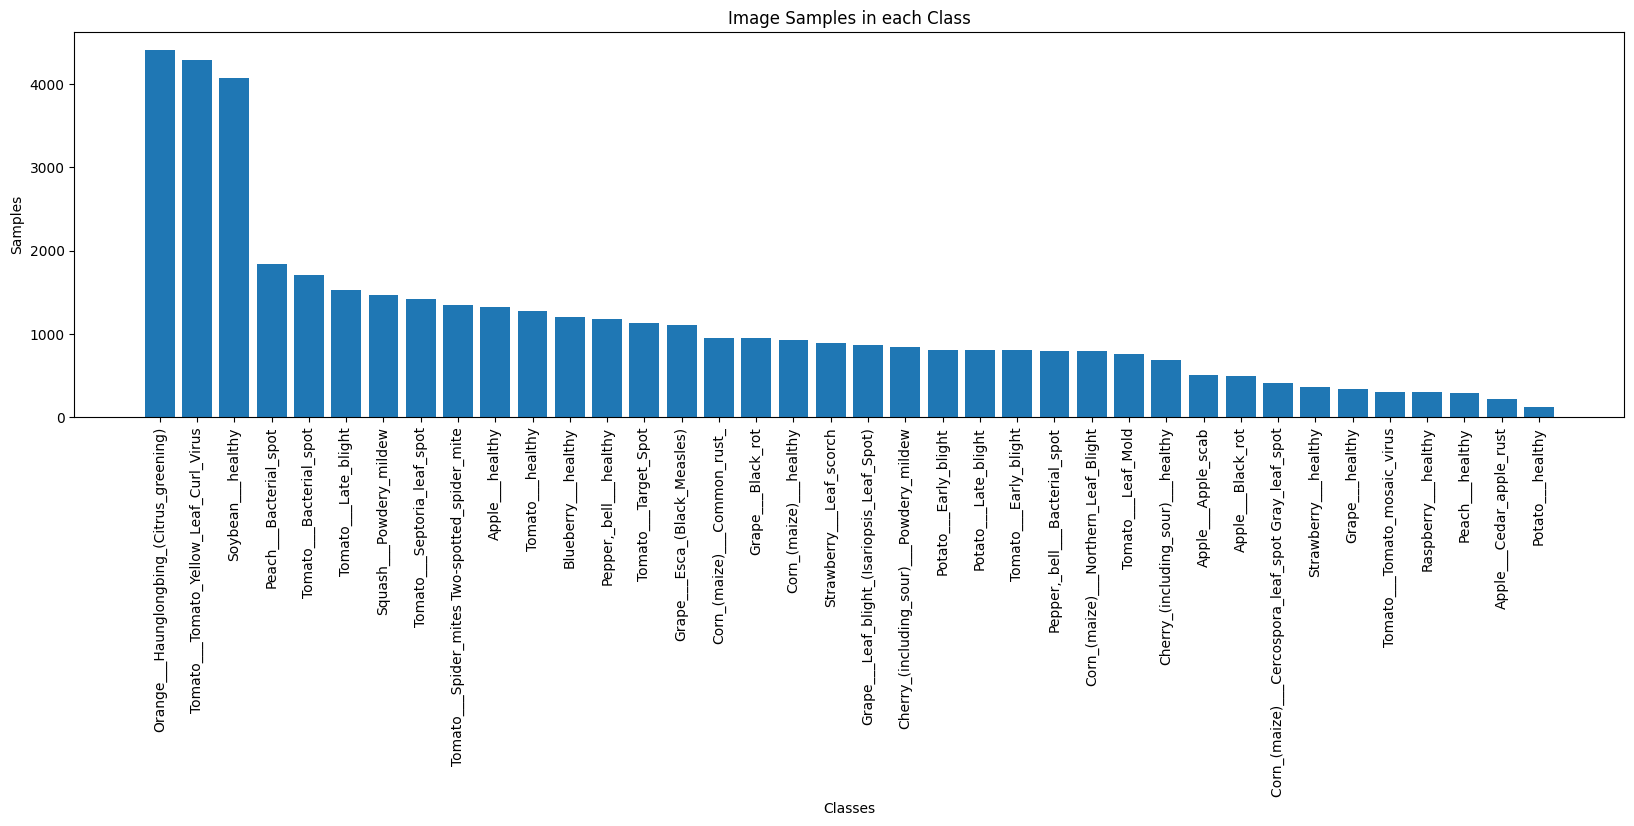

In [9]:
# Vizualize counts of classes
data = train_df['label'].value_counts()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_xlabel('Classes')
ax.set_ylabel('Samples')
ax.set_title('Image Samples in each Class')
_ = ax.bar(data.index, data)
ax.tick_params(axis='x', labelrotation=90)


There is high Class Imbalance

To address this
- Create more Images for classes with less samples using Image Augmentation
- Sample equal number of images from each class for Training Dataset

#### Setting Up Data

In [10]:
# Generating more data by Image Augmentation
path = 'dataset/augmented_dataset'
total_smaples = TRAIN_SAMPLES + VAL_SAMPLES

data_augmentation = tf.keras.Sequential(
    [layers.RandomFlip('horizontal_and_vertical'), layers.RandomRotation(0.2)])

counts = train_df['label'].value_counts()
for label, count in counts.items():
    if count < total_smaples:
        os.makedirs(f'{path}/{label}')

        images = train_df[train_df['label'] == label]['file_name']
        images = images.apply(lambda x: np.asarray(Image.open(x)))
        images = np.stack(images)
        images = tf.convert_to_tensor(images)

        for i in range(total_smaples//count):
            for j, img in enumerate(images):
                augmented_img = data_augmentation(img)
                augmented_img = Image.fromarray(
                    augmented_img.numpy().astype('uint8'))
                augmented_img.save(f'{path}/{label}/aug{i * count + j}.jpg')


In [11]:
# Adding Augmented Data to Training Data
train_df = pd.concat([train_df, load_filepaths('dataset/augmented_dataset')], ignore_index=True)


In [12]:
# Sampling Images from each class
train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=total_smaples))


In [13]:
# Label Encoding
encoder = LabelEncoder().fit(train_df['label'].unique())
train_df['label'] = encoder.transform(train_df['label'])


In [14]:
# Splitting training dataframe into training and validation dataset
val_df = shuffle(train_df.groupby('label', group_keys=False).apply(lambda x: x.iloc[TRAIN_SAMPLES:]))
train_df = shuffle(train_df.groupby('label', group_keys=False).apply(lambda x: x.iloc[:TRAIN_SAMPLES]))


In [15]:
# Creating Dataset
def load_dataframe(df):
    ds = tf.data.Dataset.from_tensor_slices((df['file_name'], df['label']))
    ds = ds.map(lambda x, y: (tf.image.decode_jpeg(tf.io.read_file(x)), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    
    # Scaling the images
    scaling_layer = tf.keras.layers.Rescaling(1.0/255)
    ds = ds.map(lambda x, y: (scaling_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # Optimize Performance
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = load_dataframe(train_df)
val_ds = load_dataframe(val_df)


#### Define Callbaack

In [16]:
class train_callback(Callback):
    def __init__(self, model, batches, epochs, target = 95, lr_factor=0.1, reset=True, epoch_patience=1, lr_patience=1):
        super(train_callback, self).__init__()
        self.model = model
        self.best_weights = self.model.get_weights()

        self.batches = batches
        self.epochs = epochs
        self.target = target
        self.lr_factor = lr_factor
        self.reset = reset
        self.epoch_patience = epoch_patience
        self.lr_patience = lr_patience

        self.bad_epoch_count = 0
        self.bad_lr_count = 0
        self.best_epoch = 0
        self.best_val_acc = 0

    def on_train_begin(self, logs=None):
        print('Initializing Training')

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)
        print('Training Complete')

    def on_train_batch_end(self, batch, logs=None):
        acc = round(logs['accuracy'] * 100)
        print(f'Processing Batch {batch} of {self.batches:.0f}, accuracy = {acc:3d}%'.ljust(50), '\r', end='')

    def on_epoch_end(self, epoch, logs=None):
        messages = []

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        acc = round(logs['accuracy'] * 100)
        val_acc = round(logs['val_accuracy'] * 100)

        if val_acc >= self.target:
            self.model.stop_training = True
            messages.append('Target Accuracy Achieved')

        else:
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch

                self.bad_epoch_count = 0
                self.bad_lr_count = 0
            else:
                self.bad_epoch_count += 1
                if self.bad_epoch_count == self.epoch_patience:
                    self.bad_epoch_count = 0
                    self.bad_lr_count += 1
                    if self.bad_lr_count == self.lr_patience:
                        messages.append(f'Training stopped at epoch {epoch} due to no further improvement')
                        self.model.stop_training = True
                    else:
                        messages.append(f'Adjusting Learning Rate')
                        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr * self.lr_factor)

                    if self.reset:
                        self.model.set_weights(self.best_weights)
                        messages.append(f'Resetting weights to epoch {self.best_epoch} weights')
        
        print(f'Epoch: {epoch}/{self.epochs}, acc = {acc:3d}%, val_acc = {val_acc:3d}%'.ljust(50))
        for message in messages:
            print(message)


#### Modelling

In [17]:
# Build Model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=(256, 256, 3), pooling='max')
x = base_model.output
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = layers.Dropout(rate=0.45)(x)
output = layers.Dense(38, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Training Model
batches = np.ceil(len(train_df)/BATCH_SIZE)

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=0, callbacks=[train_callback(model, batches, EPOCHS, lr_patience=2)])


Initializing Training
Epoch: 0/50, acc =  22%, val_acc =   3%            
Epoch: 1/50, acc =  64%, val_acc =  54%            
Epoch: 2/50, acc =  82%, val_acc =  83%            
Epoch: 3/50, acc =  89%, val_acc =  93%            
Epoch: 4/50, acc =  94%, val_acc =  91%            
Adjusting Learning Rate
Resetting weights to epoch 3 weights
Epoch: 5/50, acc =  93%, val_acc =  94%            
Epoch: 6/50, acc =  93%, val_acc =  94%            
Adjusting Learning Rate
Resetting weights to epoch 5 weights
Epoch: 7/50, acc =  93%, val_acc =  95%            
Target Accuracy Achieved
Training Complete


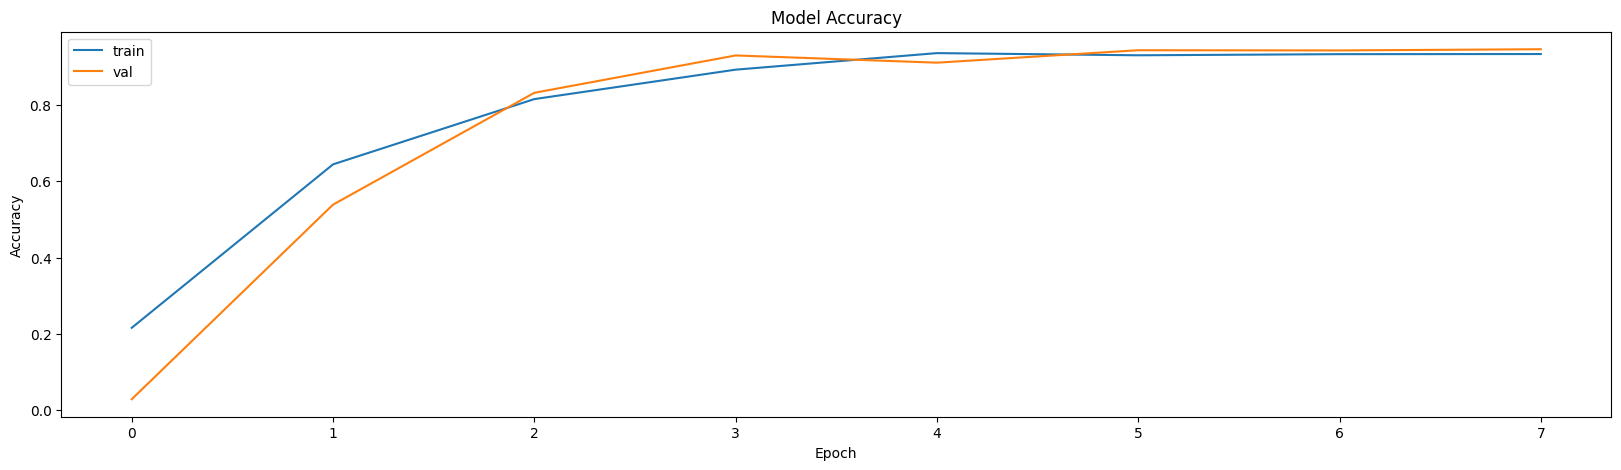

In [19]:
# Plot the Training History
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(history.history['accuracy'], label='train')
ax.plot(history.history['val_accuracy'], label='val')
_ = ax.legend()


#### Loading Test Images

In [20]:
test_df = load_filepaths('dataset/dataset/test')
test_df['label'] = encoder.transform(test_df['label'])
test_ds = load_dataframe(test_df)


#### Model Evaluation

In [21]:
# Model Accuracy on Test Data
score = model.evaluate(test_ds)
print(f'Accuracy over the test set: {round((score[1]*100), 2)}%')


340/340 [==============================] - 35s 102ms/step - loss: 6.3516 - accuracy: 0.9456
Accuracy over the test set: 94.56%
